# Reviews Feature Engineerings
## 1. Rough look at reviews text
### 1.1. Word cloud of all Yelp reviews with little preprocessing

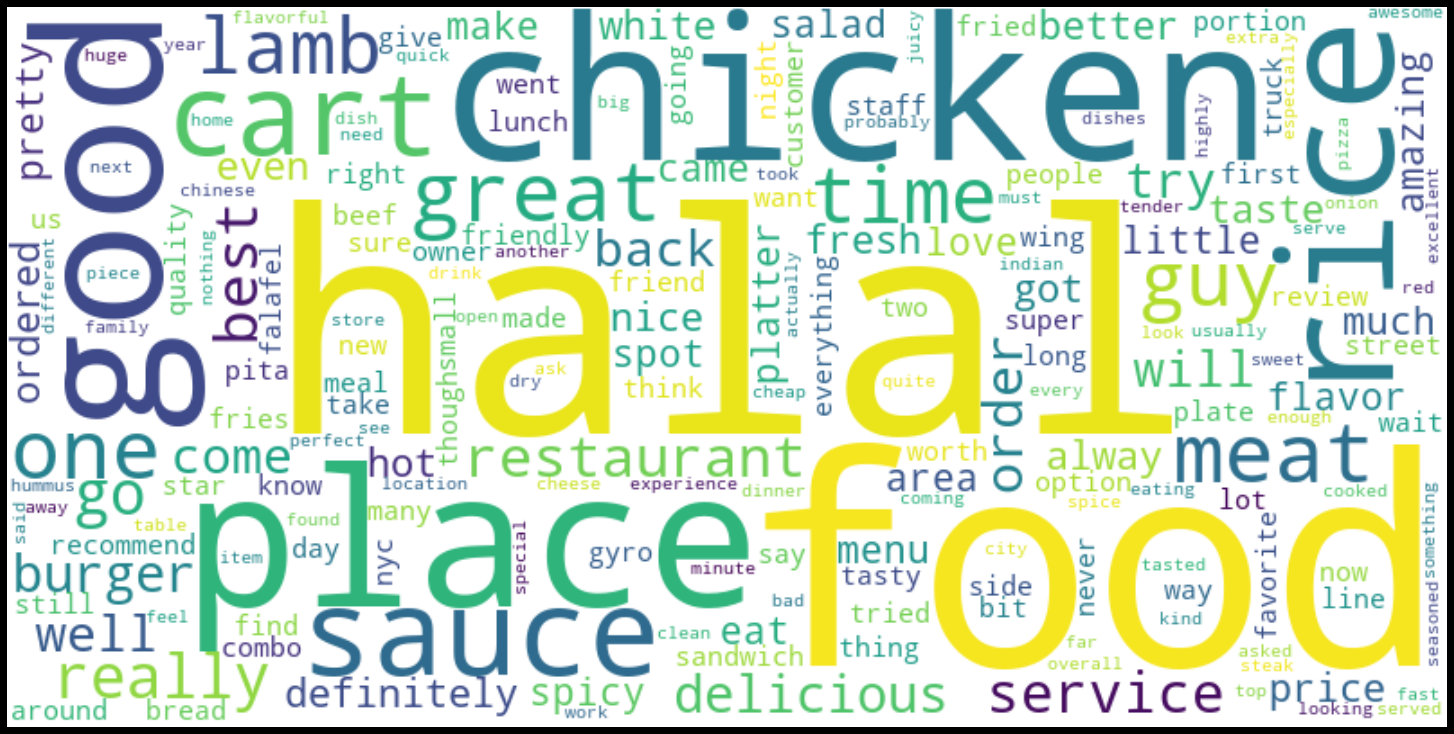

In [1]:
import string, os, sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..')+'/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)
from database import Database   

db = Database()
# get all reviews
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)

# convert the text to lower case
reviews_df['review_text'] = reviews_df['review_text'].str.lower()

# splitting and removing punctuations
all_text = reviews_df['review_text'].str.replace('\n', ' ').str.split()
all_text_cleaned = []
for text in all_text:
    text = [x.strip(string.punctuation) for x in text]
    all_text_cleaned.append(text)

reviews_text = [' '.join(text) for text in all_text_cleaned]
final_reviews_text = ' '.join(reviews_text)

# generate word cloud and plot
wc = WordCloud(background_color="white", collocations = False, width=800, height=400).generate(final_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 1.2. Remove 'halal' and other distracting words

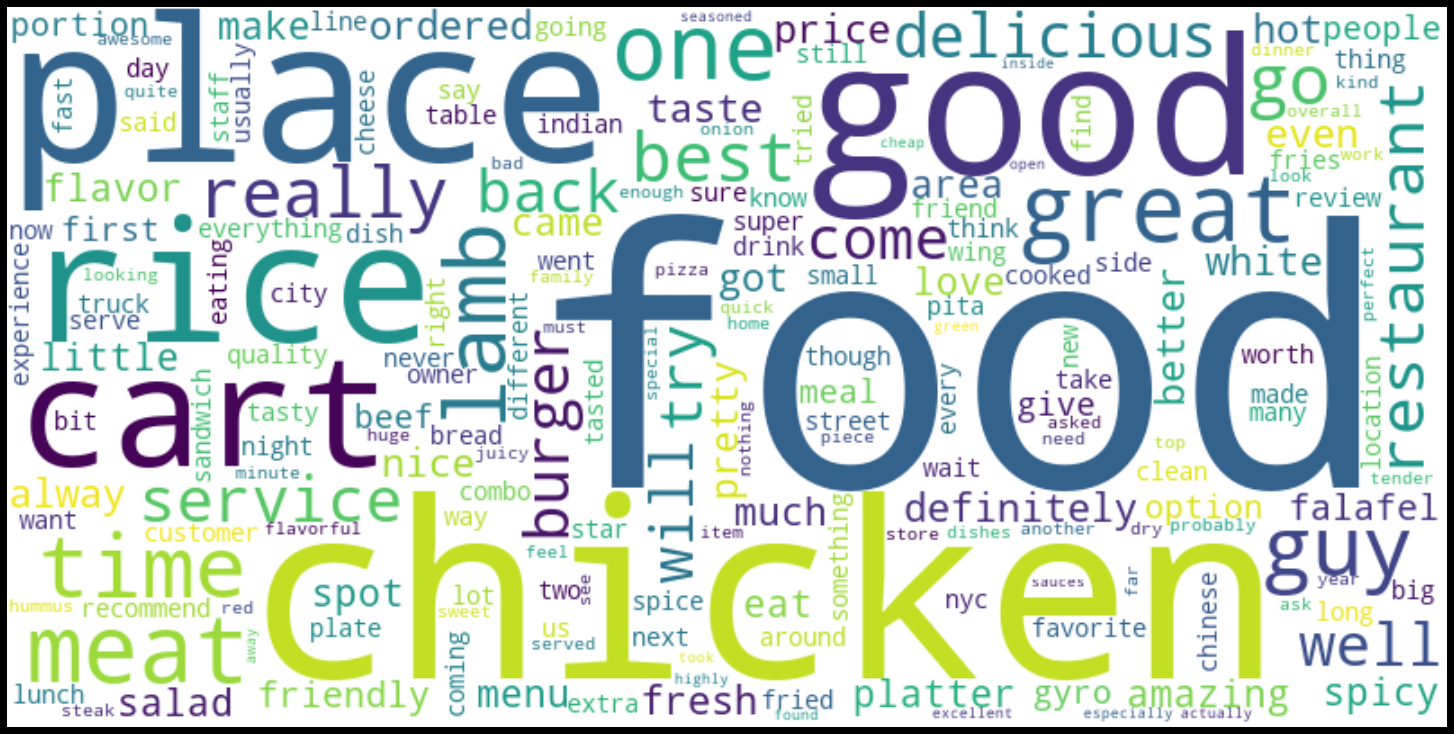

In [2]:
stopwords = set(STOPWORDS)
stopwords.update(['halal', 'order', 'sauce'])

wc = WordCloud(stopwords=stopwords, background_color="white", collocations = False, width=800, height=400).generate(final_reviews_text)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## 2. Spacy NLP

In [3]:
import os, sys
import numpy as np
# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..')+'/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)
from database import Database   

db = Database()
# get all reviews
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)

reviews_df.review_text[17]

"Tried this tiny little place while in the area looking for a quick bite. There are literally hundreds of Caribbean restaurants in the area but we just chose this one since it was brightly lit and didn't have a huge line.\nThey had a nice selection of (halal) Carib classics such as oxtail and curry chicken. I wanted to try their cow foot soup (one of my favorites) bit didn't have time. We settled on 2 beef patties and a side of sweet plantain. We also got 2 ginger beers to drink.\n\nI was hoping they would serve some trini items as I was in the mood for doubles, but no such luck. They also didn't have chicken patties, only beef, which was disappointing since I wanted to try some different items.\n\nThe patties were good, large and flavorful and flaky. The plantains were a little dry but the flavor was good and you get a good amount. Altogether the whole thing was $9.00. Great deal!\n\nService was good too, they were very friendly and answered all my questions. I would definitely go the

In [4]:
# from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
# from spacy.tokens import Doc
import en_core_web_sm
import pandas as pd


def preprocess(doc):
#     print("Before cleaning, this doc has {} tokens.".format(len(doc)))
    indexes = []
    for index, token in enumerate(doc):
        if (token.pos_  in ('PUNCT', 'NUM', 'SYM') or token.is_stop):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    np_array = np.delete(np_array, indexes, axis = 0)
    cleaned_text = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in indexes])
    cleaned_text.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    cleaned_text.set_extension('is_parsed', default=True, force=True)
    cleaned_text.is_parsed = True
#     print("After cleaning, this doc has {} tokens.".format(len(cleaned_text)))
    return cleaned_text

nlp = en_core_web_sm.load()
# nlp.add_pipe(preprocess, name='preprocess', last=True)


### 2.1. Group reviews by restaurant and run nlp

In [5]:
# group by restaurnat id
grouped_reviews_df = reviews_df.groupby('restaurant_id').agg(lambda x: ' '.join(x)) # combine review text
grouped_reviews_df['review_date'] = grouped_reviews_df['review_date'].apply(lambda x: x.split()) # make dates list
grouped_reviews_df['review_count'] = grouped_reviews_df['review_date'].apply(lambda x: len(x)) # count reviews per restaurnat

grouped_reviews_df['doc'] = grouped_reviews_df['review_text'].apply(lambda x: nlp(x))

### 2.2. Extract tokens, lemma, and POS after cleaning

In [6]:
# tokens = []
# lemma = []
# pos = []
# for ind, doc in grouped_reviews_df['processed_text'].iteritems():
#     if doc.is_parsed:
#         tokens.append([n.text for n in doc])
#         lemma.append([n.lemma_ for n in doc])
#         pos.append([n.pos_ for n in doc])
#     else:
#         # We want to make sure that the lists of parsed results have the
#         # same number of entries of the original Dataframe, so add some blanks in case the parse fails
#         tokens.append(None)
#         lemma.append(None)
#         pos.append(None)

# grouped_reviews_df['species_tokens'] = tokens
# grouped_reviews_df['species_lemma'] = lemma
# grouped_reviews_df['species_pos'] = pos

### 2.3. Extract the frequency of words at position X from the word 'halal'

In [7]:
def get_halal_indices(lemma_list):
    indices = np.where(np.array(lemma_list) == 'halal')[0]
    return indices

def get_positions_lemma(df_row, target_position):
    position_str = str(target_position)+ ' after' if target_position > 0 else ' before'
    df = pd.DataFrame()
    global c
    for ind in df_row['halal_indices']:
        row = dict(index=int(c))
        c+=1
        row[position_str] = df_row.species_lemma[ind+target_position]
        df = df.append(row, i)
    return df

In [8]:
# get indices of 'halal' in tokens
grouped_reviews_df['halal_indices'] = grouped_reviews_df['species_lemma'].apply(lambda texts: get_halal_indices(texts))

# get word frequency per position
target_pos_list = [-3,-2,-1,1,2,3]
positions_df = pd.DataFrame(data = range(len([st for row in grouped_reviews_df['halal_indices'] for st in row])), columns=['index']) 
positions_df.set_index('index')

for target in target_pos_list:
    position_str = str(target) + (' after' if target > 0 else ' before')
    c=0
    for _,row in grouped_reviews_df.iterrows():
        for _,ind in enumerate(row['halal_indices']):
            try:
                positions_df.loc[c, str(position_str)] = row['species_lemma'][ind+target]
            except:
                positions_df.loc[c, str(position_str)] = None
            c+=1

KeyError: 'halal_indices'

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

columns = positions_df.columns[1:]
fig = make_subplots(rows=len(columns), cols=1, vertical_spacing=0.05)

for i, col in enumerate(columns):
    fig.append_trace(go.Bar(
        x=positions_df[col].value_counts().index,
        y=positions_df[col].value_counts().values,
        name=col
    ), row=(i+1), col=1)
    fig.update_layout(autosize=False, width=1000, height=1000)

fig.show()

### 2.3. Extract words at positions x from 'halal' using spacy.matcher

In [50]:
from spacy.matcher import Matcher

# initialize matcher
matcher = Matcher(nlp.vocab)

# specify match pattern
pattern = [{'LOWER': 'halal'}] # using general version first
matcher.add('halal', None, pattern)

# get word, part-of-speech and lemma list for each position beofre/ after 'halal'
matcher_df = pd.DataFrame(data = range(reviews_df.shape[0]), columns=['index'])
matcher_df.set_index('index')
position_list = range(-2, 3, 1)
c=0
for i, doc in grouped_reviews_df['doc'].iteritems():
#     doc = nlp(grouped_reviews_df.loc[i, 'review_text'])
#     grouped_reviews_df.loc[i, 'doc'] = doc
    match = matcher(doc)
    for match_id, start, end in match:
        for position in position_list:
            if start+position < len(doc):
                matcher_df.loc[c, str(position)] = doc[start+position]
                matcher_df.loc[c, str(position) + '_pos'] = doc[start+position].pos_
                matcher_df.loc[c, str(position) + '_lemma'] = doc[start+position].lemma_
            else:
                print('Doc lenght {0} and item is at {1}'.format(len(doc), start+position))
                matcher_df.loc[c, str(position)] = None
                matcher_df.loc[c, str(position) + '_pos'] = None
                matcher_df.loc[c, str(position) + '_lemma'] = None
        matcher_df.loc[c, 'sent'] = ' '.join(doc[start:end].sent.text.split())
        c+=1
        print('[{0}/{1}]'.format(c, matcher_df.shape[0]), flush=True, end='\r')

Doc lenght 135 and item is at 135
Doc lenght 553 and item is at 553
Doc lenght 212 and item is at 212
Doc lenght 212 and item is at 213
Doc lenght 475 and item is at 475
Doc lenght 350 and item is at 350
Doc lenght 131 and item is at 131
Doc lenght 397 and item is at 397
Doc lenght 202 and item is at 202


In [98]:
matcher_df.groupby(['-1_pos', '-1_lemma']).size()

-1_pos  -1_lemma
ADJ     -           12
        3rd          1
        53rd         1
        6th         19
        Most         5
                    ..
VERB    wabt         1
        want        16
        way          1
        zabiha       3
X       mention-     1
Length: 736, dtype: int64

### 2.4. Explore distribution of reviews' dates

In [ ]:
# distribution of number of reviews per restaurant
import seaborn as sns

plt.figure(figsize=(14,10))
sns.distplot(grouped_reviews_df.review_count.value_counts(), kde=False)
plt.title('Distribution of review num per restaurant', size=14)
plt.xlabel('Number of reviews', size=14)
plt.ylabel('Counts', size=14)
plt.show()

In [ ]:
# distribution of all by (quarter, year) review dates
ax, fig = plt.subplots(figsize=(18,8))
reviews_df.review_date = reviews_df['review_date'].astype('datetime64')
reviews_df.groupby([reviews_df.review_date.dt.year, reviews_df.review_date.dt.quarter])['id'].count().plot(kind='bar')
plt.title('Distribution of halal reviews dates', size=14)
plt.xlabel('Review date (year, quarter)', size=14)
plt.show()

In [ ]:
# individual distribution of reviews' dates of the 6 top restaurants with most reviews
id_mask_top6 = grouped_reviews_df.nlargest(6, 'review_count').index

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,14))

for ax, res_id in zip(axes.flat, id_mask_top6):
    data = reviews_df[reviews_df['restaurant_id'] == res_id].groupby([reviews_df.review_date.dt.year,
                                            reviews_df.review_date.dt.quarter])['id'].count()
    x = data.index
    y = data.values
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_title('Distribution for id:{}'.format(res_id), size=14)
    ax.set_xlabel('Review date (quarter, year)', size=14)
    ax.set_xticklabels(labels=x, rotation=45, ha='right')
plt.tight_layout()
plt.show()


Improve by standarizing xticks

### 2.5. Examine the presence of 'non-halal' words

In [ ]:
non_halal_words = ['pork', 'ham', 'bacon', 'wine', 'beer', 'alcohol', 'shortening', 'lard'] #expand list further

# presence in all reviews
plt.figure(figsize=(14,8))

reviews_df['review_text'] = reviews_df['review_text'].str.lower()
non_halal_match = reviews_df['review_text'].str.contains('|'.join(non_halal_words))
non_halal_match_count = [sum(non_halal_match), len(non_halal_match)-sum(non_halal_match)]
g = sns.barplot(x=['Contains non-halal words','Does not contains'], y=non_halal_match_count)
g.set_title('Reviews containing non-halal words', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

How does this align with target feature?

In [ ]:
# presence in reviews per restaurant
plt.figure(figsize=(14,8))
non_halal_res = reviews_df[non_halal_match]['restaurant_id'].nunique()
non_halal_res_count = [non_halal_res, reviews_df['restaurant_id'].nunique()-non_halal_res]
g = sns.barplot(x=['Restaurants with non-halal words','Restaurants w/o not contains'], y=non_halal_res_count)
g.set_title('Restaurants with reviews containing non-halal words', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

### 2.6. Extract negation from grouped reviews